Uses phase_desc_ext

- Compute semantic similarity between abstracts and phase descriptions (from phase_desc.json)
- Combine similarity with query-based priors to assign phases
- Analyze phase distributions and confidence

Results:
- Semantic phase probabilities are generally low and close together → weak semantic separation
- Phase 3 (Optimization) becomes dominant for most abstracts when using normal phase_desc.
- Phase 1 is equally dominant when using extended phase_desc.
- Query-based priors strongly influence the final phase assignment, since the semantic separation is so weak.
- The written phase descriptions also becomes too influential. 

Regarding the results:
- This is not necessarily wrong (that most ML-for-manufacturing research focuses on optimization)
- However, clearer and more detailed phase descriptions are likely needed
- A bibliometric clustering step should also be introduced before lifecycle phase mapping to reveal natural topic structure in the literature

In [1]:
# Imports

import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths

data_path = Path("../../data/short-raw-refs-abs")
processed_abstracts_path = Path("../../data/processed/abstracts")
phase_config_path = Path("../../phases/phase_desc_ext.json")
save_path = processed_abstracts_path / "semantic_analysis"


# Ensure directories exist
for p in [data_path, processed_abstracts_path, save_path]:
    p.mkdir(parents=True, exist_ok=True)

print("All directories verified/created.")


All directories verified/created.


In [3]:
# Load abstracts dataset

abstracts_path = processed_abstracts_path / "abstracts.csv"
df = pd.read_csv(abstracts_path)

print(f"Loaded {len(df)} abstracts from {df['query_id'].nunique()} queries.")
df.head()

Loaded 52290 abstracts from 24 queries.


,query_id,eid,doi,title,abstract,clean_abs
0,ml_anomaly_detection_production,2-s2.0-105018574505,10.1016/j.measurement.2025.119261,Distillation anomaly and fault detection based...,© 2025 The Author(s)The detection of anomalies...,"Indeed, highly efficient systems do not always..."
1,ml_anomaly_detection_production,2-s2.0-105019192533,10.1007/978-3-032-06118-8_30,From Lab to Factory: Pitfalls and Guidelines f...,"© The Author(s), under exclusive license to Sp...",The detection and localization of quality-rela...
2,ml_anomaly_detection_production,2-s2.0-105016669957,10.1007/978-3-032-04200-2_5,Intelligent Defect Detection for Manufacturing...,"© The Author(s), under exclusive license to Sp...","In modern Industry, I4.0, artificial intellige..."
3,ml_anomaly_detection_production,2-s2.0-85218693791,10.1038/s41598-025-90810-w,Hybrid machine learning framework for predicti...,© The Author(s) 2025.The critical necessity fo...,The critical necessity for sophisticated predi...
4,ml_anomaly_detection_production,2-s2.0-105018301117,10.1016/j.comnet.2025.111753,BGP anomaly detection using the raw internet t...,© 2025 The AuthorsThe Border Gateway Protocol ...,"Hence, detecting any anomaly concerning BGP an..."


In [4]:
# Count how many rows each query_id has
query_counts = df["query_id"].value_counts().to_dict()

# Create a copy and map the counts to each row
df = df.copy()
df["query_size"] = df["query_id"].map(query_counts)

# Sort so that query groups with fewer rows are prioritized
df_sorted = df.sort_values(by="query_size", ascending=True)

# Remove duplicate DOIs, keeping the one in the smallest query group
df_dedup = df_sorted.drop_duplicates(subset="doi", keep="first").drop(columns=["query_size"])

# Print results
print("Original dataset size:", len(df))
print("After removing duplicates:", len(df_dedup))
print("Remaining duplicate DOIs:", df_dedup["doi"].duplicated().sum())

df = df_dedup

Original dataset size: 52290
After removing duplicates: 33130
Remaining duplicate DOIs: 0


In [5]:
# Load phase descriptions from JSON

with phase_config_path.open("r", encoding="utf-8") as f:
    phases = json.load(f)

phase_ids = list(phases.keys())
phase_texts = [phases[p]["description"] for p in phase_ids]

for pid, ptext in zip(phase_ids, phase_texts):
    print(f"{pid}: {ptext[:80]}...")


phase_1: Research and activities before detailed design or production setup. Focus on def...
phase_2: Designing products and implementing production systems. Includes detailed engine...
phase_3: Continuous improvement of established products or production processes using ope...
phase_4: Focus on products in operation or at end-of-life. Activities include field data ...


In [6]:
# Phase priors per query_id
# Format: [Phase1_Planning, Phase2_Development/Production, Phase3_Optimization, Phase4_Use/Reuse]

phase_priors = {
    # Use / Reuse — dominant Phase 4
    "ml_inservice_monitoring":       [0.05, 0.20, 0.35, 0.40],
    "ml_remanufacturing":            [0.05, 0.10, 0.15, 0.70],
    "ml_disassembly":                [0.05, 0.25, 0.20, 0.50],
    "ml_end_of_life":                [0.05, 0.10, 0.15, 0.70],
    "ml_recycling_manufacturing":    [0.05, 0.30, 0.20, 0.45],
    "ml_sustainability_product":     [0.30, 0.10, 0.10, 0.50],

    # Very broad — spans production & optimization
    "ml_manufacturing":              [0.10, 0.45, 0.40, 0.05],

    # Planning phase focus
    "ml_planning_production":        [0.75, 0.15, 0.10, 0.00],
    "ml_product_design":             [0.80, 0.15, 0.05, 0.00],
    "ml_plm":                        [0.40, 0.10, 0.15, 0.35],  # lifecycle both ends

    # Development / Production execution focus
    "ml_product_development":        [0.20, 0.60, 0.20, 0.00],
    "ml_defect_detection":           [0.10, 0.65, 0.25, 0.00],
    "ml_quality_control":            [0.05, 0.55, 0.40, 0.00],
    "ml_automation":                 [0.05, 0.70, 0.25, 0.00],
    "ml_robotics_production":        [0.05, 0.75, 0.20, 0.00],

    # Supply chain → planning weighted, but still operational relevance
    "ml_supply_chain":               [0.45, 0.35, 0.15, 0.05],

    # Optimization focused
    "ml_manufacturing_optimization": [0.05, 0.25, 0.70, 0.00],
    "ml_production_optimization":    [0.05, 0.25, 0.70, 0.00],
    "ml_process_optimization":       [0.05, 0.25, 0.70, 0.00],
    "ml_process_control":            [0.05, 0.20, 0.75, 0.00],
    "ml_process_modeling":           [0.10, 0.20, 0.70, 0.00],
    "ml_predictive_maintenance":     [0.05, 0.20, 0.60, 0.15],
    "ml_anomaly_detection_production":[0.05, 0.20, 0.70, 0.05],

    # Use / Reuse specific — RUL informs lifetime while still in operation
    "ml_rul":                        [0.05, 0.15, 0.30, 0.50],
}



def get_phase_prior(query_id):
    # Return a valid probability vector for the query
    prior = phase_priors.get(query_id)
    if prior is None:
        # Default weakly uniform prior if unknown query_id
        prior = np.array([0.25, 0.25, 0.25, 0.25], dtype=float)
    else:
        prior = np.array(prior, dtype=float)
        prior = prior / prior.sum()
    return prior


In [7]:
# Define embedding and similarity helpers (to be implemented with your chosen model)

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # In use
light_model = SentenceTransformer("sentence-transformers/all-MiniLM-L12-v2")

def get_embedding(text):
    """
    Return a vector 
    ing for the given text.
    Uses a SentenceTransformer model.
    """
    if not isinstance(text, str):
        text = ""
    emb = model.encode(
        text,
        show_progress_bar=False,
        convert_to_numpy=True,
        normalize_embeddings=True,
    )
    return emb

def cosine_similarity(a, b):
    # Compute cosine similarity between two 1D vectors
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)


In [8]:
# Precompute embeddings for all phase descriptions

phase_embeddings = []
for pid, ptext in zip(phase_ids, phase_texts):
    emb = get_embedding(ptext)
    phase_embeddings.append(emb)

phase_embeddings = np.vstack(phase_embeddings)
phase_embeddings.shape


(4, 768)

In [9]:
# Compute semantic phase scores for each abstract with progress bar

from tqdm import tqdm

sim_cols = ["sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4"]

# Initialize columns
for col in sim_cols:
    df[col] = np.nan

batch_size = 512  # Adjust based on GPU memory

for start in tqdm(range(0, len(df), batch_size), desc="Embedding abstracts"):
    end = min(start + batch_size, len(df))
    batch = df.iloc[start:end]

    sims = []
    for text in batch["clean_abs"].astype(str).tolist():
        e_abs = get_embedding(text)
        sim_vec = [cosine_similarity(e_abs, pe) for pe in phase_embeddings]
        sims.append(sim_vec)

    sims = np.array(sims)
    exp_sims = np.exp(sims - sims.max(axis=1, keepdims=True))
    probs = exp_sims / exp_sims.sum(axis=1, keepdims=True)

    df.loc[batch.index, sim_cols] = probs

print("Semantic phase scores computed.")
df[sim_cols].head()


Embedding abstracts: 100%|██████████| 65/65 [07:01<00:00,  6.49s/it]

Semantic phase scores computed.


,sim_phase_1,sim_phase_2,sim_phase_3,sim_phase_4
3373,0.245033,0.254934,0.234171,0.265862
3374,0.233222,0.251500,0.235950,0.279328
3387,0.247294,0.245654,0.246030,0.261022
3388,0.254648,0.245610,0.249727,0.250015
3389,0.238154,0.238922,0.242455,0.280469


In [10]:
# Combine query priors and semantic scores into final phase probabilities

alpha = 0.0 # Weight on priors (0=only semantics, 1=only priors)

final_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df[final_cols] = np.nan

primary_labels = []
secondary_labels = []

for idx, row in df.iterrows():
    prior = get_phase_prior(row["query_id"])
    sem = row[sim_cols].values.astype(float)

    # Safety check for NaN
    if np.any(~np.isfinite(sem)):
        sem = np.ones(4) / 4.0

    combined = alpha * prior + (1 - alpha) * sem
    combined = combined / combined.sum()

    df.loc[idx, final_cols] = combined

    # Determine primary and secondary phases
    order = np.argsort(-combined)  # descending
    primary = order[0] + 1  # 1-based phase index
    secondary = order[1] + 1

    primary_labels.append(primary)
    secondary_labels.append(secondary)

df["primary_phase"] = primary_labels
df["secondary_phase"] = secondary_labels

print("Final phase probabilities and labels added.")
df[["query_id", "primary_phase", "secondary_phase"] + final_cols].head()


Final phase probabilities and labels added.


,query_id,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4
3373,ml_end_of_life,4,2,0.245033,0.254934,0.234171,0.265862
3374,ml_end_of_life,4,2,0.233222,0.251500,0.235950,0.279328
3387,ml_end_of_life,4,1,0.247294,0.245654,0.246030,0.261022
3388,ml_end_of_life,1,4,0.254648,0.245610,0.249727,0.250015
3389,ml_end_of_life,4,3,0.238154,0.238922,0.242455,0.280469


In [11]:
# Save extended dataset with phase information

out_path = save_path / "abstracts_with_phases.csv"
df.to_csv(out_path, index=False)
print(f"Saved dataset with phases to: {out_path}")


Saved dataset with phases to: ../../data/processed/abstracts/semantic_analysis/abstracts_with_phases.csv


In [24]:
# Save dataset with just one phase-column

# Compute single phase column based on highest probability
phase_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
df["phase"] = df[phase_cols].idxmax(axis=1).str.extract('(\d+)').astype(int)

# Drop old phase columns
df_min = df.drop(columns=phase_cols + [
    "sim_phase_1", "sim_phase_2", "sim_phase_3", "sim_phase_4",
    "primary_phase", "secondary_phase"
])

# Save minimal dataset
out_path_min = save_path / "abstracts_min_phases.csv"
df_min.to_csv(out_path_min, index=False)

print(f"Saved minimal dataset with single phase column to: {out_path_min}")

Saved minimal dataset with single phase column to: ../../data/processed/abstracts/semantic_analysis/abstracts_min_phases.csv


primary_phase
1     2672
2     8892
3    15580
4     5986
Name: count, dtype: int64


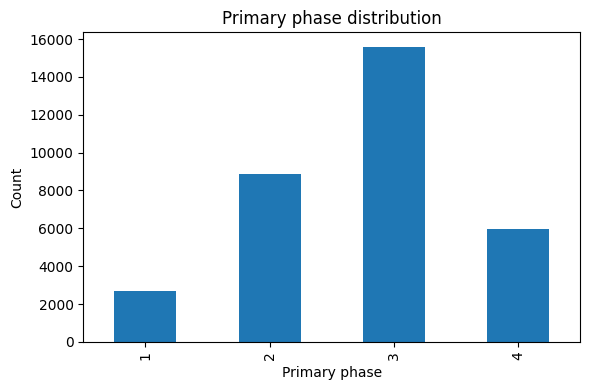

In [12]:
# Plot primary phase distribution

phase_counts = df["primary_phase"].value_counts().sort_index()
print(phase_counts)

plt.figure(figsize=(6,4))
phase_counts.plot(kind="bar")
plt.xlabel("Primary phase")
plt.ylabel("Count")
plt.title("Primary phase distribution")
plt.tight_layout()
plt.show()


In [23]:
# Inspect phase distribution per query_id

phase_query_ct = pd.crosstab(df["query_id"], df["primary_phase"], normalize="index")
phase_query_ct = phase_query_ct.rename(columns=lambda x: f"phase_{x}")

phase_query_ct.head(25)


primary_phase,phase_1,phase_2,phase_3,phase_4
query_id,,,,
ml_anomaly_detection_production,0.003279,0.037705,0.863934,0.095082
ml_automation,0.024777,0.457879,0.404361,0.112983
ml_defect_detection,0.000000,0.383607,0.375410,0.240984
ml_disassembly,0.040590,0.324723,0.409594,0.225092
ml_end_of_life,0.098039,0.058824,0.019608,0.823529
ml_inservice_monitoring,0.097561,0.097561,0.458537,0.346341
ml_manufacturing,0.044887,0.402850,0.410289,0.141975
ml_manufacturing_optimization,0.075750,0.535017,0.333492,0.055741
ml_planning_production,0.224178,0.187793,0.467136,0.120892


In [14]:
# Show queries most dominated by each phase

for p in [1, 2, 3, 4]:
    col = f"phase_{p}"
    print(f"\nTop queries for {col}:")
    display(phase_query_ct[col].sort_values(ascending=False).head(10))



Top queries for phase_1:


query_id
ml_product_development           0.235595
ml_planning_production           0.224178
ml_product_design                0.221782
ml_production_optimization       0.175569
ml_sustainability_product        0.173858
ml_supply_chain                  0.123055
ml_process_modeling              0.101382
ml_end_of_life                   0.098039
ml_inservice_monitoring          0.097561
ml_manufacturing_optimization    0.075750
Name: phase_1, dtype: float64


Top queries for phase_2:


query_id
ml_robotics_production           0.563536
ml_process_optimization          0.557692
ml_manufacturing_optimization    0.535017
ml_automation                    0.457879
ml_product_design                0.406931
ml_manufacturing                 0.402850
ml_defect_detection              0.383607
ml_recycling_manufacturing       0.359223
ml_quality_control               0.343921
ml_disassembly                   0.324723
Name: phase_2, dtype: float64


Top queries for phase_3:


query_id
ml_anomaly_detection_production    0.863934
ml_process_control                 0.711340
ml_process_modeling                0.631336
ml_predictive_maintenance          0.614426
ml_production_optimization         0.599168
ml_quality_control                 0.567360
ml_planning_production             0.467136
ml_inservice_monitoring            0.458537
ml_manufacturing                   0.410289
ml_disassembly                     0.409594
Name: phase_3, dtype: float64


Top queries for phase_4:


query_id
ml_end_of_life                0.823529
ml_rul                        0.634164
ml_remanufacturing            0.525253
ml_recycling_manufacturing    0.504854
ml_sustainability_product     0.401015
ml_plm                        0.375546
ml_predictive_maintenance     0.353443
ml_inservice_monitoring       0.346341
ml_supply_chain               0.268741
ml_defect_detection           0.240984
Name: phase_4, dtype: float64

In [15]:
# Compute confidence metrics for phase assignment

df["phase_max_prob"] = df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].max(axis=1)

# Gap between primary and secondary phases
sorted_probs = np.sort(df[["phase_p1", "phase_p2", "phase_p3", "phase_p4"]].values, axis=1)
df["phase_margin"] = sorted_probs[:, -1] - sorted_probs[:, -2]

df[["primary_phase", "secondary_phase", "phase_max_prob", "phase_margin"]].describe()


,primary_phase,secondary_phase,phase_max_prob,phase_margin
count,33130.000000,33130.000000,33130.000000,3.313000e+04
mean,2.750981,2.709176,0.266489,1.153896e-02
std,0.842436,1.055079,0.008673,9.649090e-03
min,1.000000,1.000000,0.250300,3.484396e-07
25%,2.000000,2.000000,0.259865,4.033978e-03
50%,3.000000,3.000000,0.265175,9.146077e-03
75%,3.000000,4.000000,0.271789,1.670290e-02
max,4.000000,4.000000,0.316873,7.458706e-02


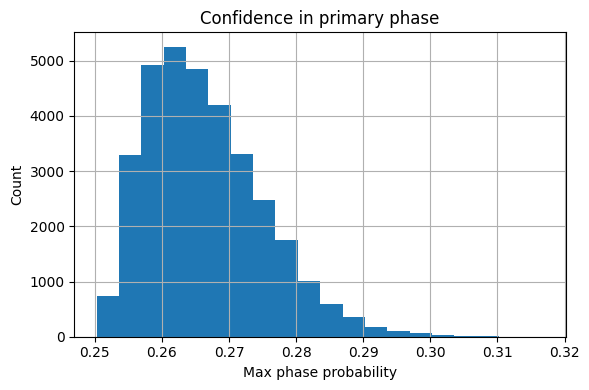

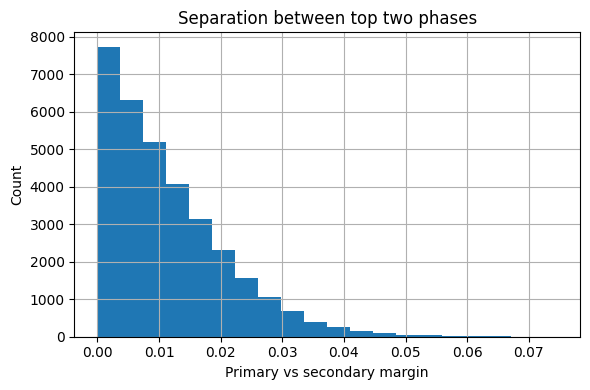

In [16]:
# Plot distributions of confidence and margin

plt.figure(figsize=(6,4))
df["phase_max_prob"].hist(bins=20)
plt.xlabel("Max phase probability")
plt.ylabel("Count")
plt.title("Confidence in primary phase")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
df["phase_margin"].hist(bins=20)
plt.xlabel("Primary vs secondary margin")
plt.ylabel("Count")
plt.title("Separation between top two phases")
plt.tight_layout()
plt.show()


In [17]:
# Inspect low-confidence samples

low_conf_mask = df["phase_max_prob"] < 0.5
print(f"Low-confidence abstracts (<0.5): {low_conf_mask.sum()}")

df_low_conf = df[low_conf_mask].sort_values("phase_max_prob").head(20)
df_low_conf[[
    "query_id",
    "doi",
    "primary_phase",
    "secondary_phase",
    "phase_p1",
    "phase_p2",
    "phase_p3",
    "phase_p4",
    "clean_abs"
]]


Low-confidence abstracts (<0.5): 33130


,query_id,doi,primary_phase,secondary_phase,phase_p1,phase_p2,phase_p3,phase_p4,clean_abs
1519,ml_automation,10.1557/s43577-023-00490-y,2,4,0.249257,0.250300,0.250151,0.250292,Low-dimensional hybrid perovskites combine the...
21343,ml_manufacturing_optimization,10.1007/978-3-031-96631-6_21,1,3,0.250432,0.250224,0.250274,0.249070,Artificial intelligence (AI) fundamentally tra...
44555,ml_production_optimization,10.18687/LACCEI2022.1.1.616,4,1,0.250438,0.249131,0.249929,0.250501,All rights reserved.The problem addressed the ...
17996,ml_manufacturing,10.1080/02580136.2021.1941652,2,1,0.250410,0.250506,0.248922,0.250162,The Fourth Industrial Revolution (4IR) and acc...
51525,ml_sustainability_product,10.1016/j.biombioe.2024.107490,1,4,0.250578,0.249479,0.249865,0.250078,"In this study, activated carbon derived from s..."
10477,ml_manufacturing,10.1007/s00170-024-14812-0,2,1,0.250661,0.250670,0.248385,0.250283,", part of Springer Nature 2024.In this article..."
40092,ml_production_optimization,10.3390/en18102523,4,2,0.249451,0.250039,0.249791,0.250720,Unconventional reservoirs are characterized by...
22336,ml_manufacturing_optimization,10.1007/s12551-025-01360-4,2,4,0.249678,0.250811,0.249137,0.250374,The applications of immobilized enzymes in ind...
17160,ml_manufacturing,10.3390/pr9071157,1,3,0.250833,0.249540,0.250148,0.249479,"Licensee MDPI, Basel, Switzerland.Suppliers ar..."
39398,ml_production_optimization,10.1016/j.aquaeng.2025.102561,4,3,0.248402,0.250152,0.250559,0.250888,This study extends our previous work on using ...


In [18]:
# Aggregate mean phase probabilities per query_id

phase_prob_cols = ["phase_p1", "phase_p2", "phase_p3", "phase_p4"]
query_phase_means = df.groupby("query_id")[phase_prob_cols].mean()

query_phase_means.head()


,phase_p1,phase_p2,phase_p3,phase_p4
query_id,,,,
ml_anomaly_detection_production,0.228395,0.245163,0.272311,0.254131
ml_automation,0.235754,0.258639,0.257367,0.248239
ml_defect_detection,0.227902,0.258314,0.259038,0.254746
ml_disassembly,0.242353,0.252108,0.253692,0.251847
ml_end_of_life,0.241600,0.246381,0.242079,0.269939


In [19]:
# Show queries with highest mean probability for each phase

for i, col in enumerate(phase_prob_cols, start=1):
    print(f"\nTop queries by mean {col}:")
    display(query_phase_means[col].sort_values(ascending=False).head(10))



Top queries by mean phase_p1:


query_id
ml_product_development           0.251189
ml_product_design                0.250852
ml_planning_production           0.248855
ml_sustainability_product        0.247840
ml_production_optimization       0.247351
ml_supply_chain                  0.244732
ml_plm                           0.244136
ml_manufacturing_optimization    0.243666
ml_process_modeling              0.243050
ml_disassembly                   0.242353
Name: phase_p1, dtype: float64


Top queries by mean phase_p2:


query_id
ml_process_optimization          0.261645
ml_robotics_production           0.259555
ml_manufacturing_optimization    0.259186
ml_automation                    0.258639
ml_defect_detection              0.258314
ml_quality_control               0.257929
ml_manufacturing                 0.255946
ml_product_design                0.255768
ml_recycling_manufacturing       0.255299
ml_remanufacturing               0.255026
Name: phase_p2, dtype: float64


Top queries by mean phase_p3:


query_id
ml_anomaly_detection_production    0.272311
ml_predictive_maintenance          0.268240
ml_process_control                 0.267780
ml_rul                             0.266459
ml_quality_control                 0.262664
ml_process_modeling                0.262420
ml_defect_detection                0.259038
ml_process_optimization            0.258549
ml_production_optimization         0.258237
ml_inservice_monitoring            0.257770
Name: phase_p3, dtype: float64


Top queries by mean phase_p4:


query_id
ml_rul                             0.271347
ml_end_of_life                     0.269939
ml_predictive_maintenance          0.263463
ml_remanufacturing                 0.262792
ml_recycling_manufacturing         0.258260
ml_inservice_monitoring            0.255814
ml_defect_detection                0.254746
ml_sustainability_product          0.254186
ml_anomaly_detection_production    0.254131
ml_plm                             0.253237
Name: phase_p4, dtype: float64

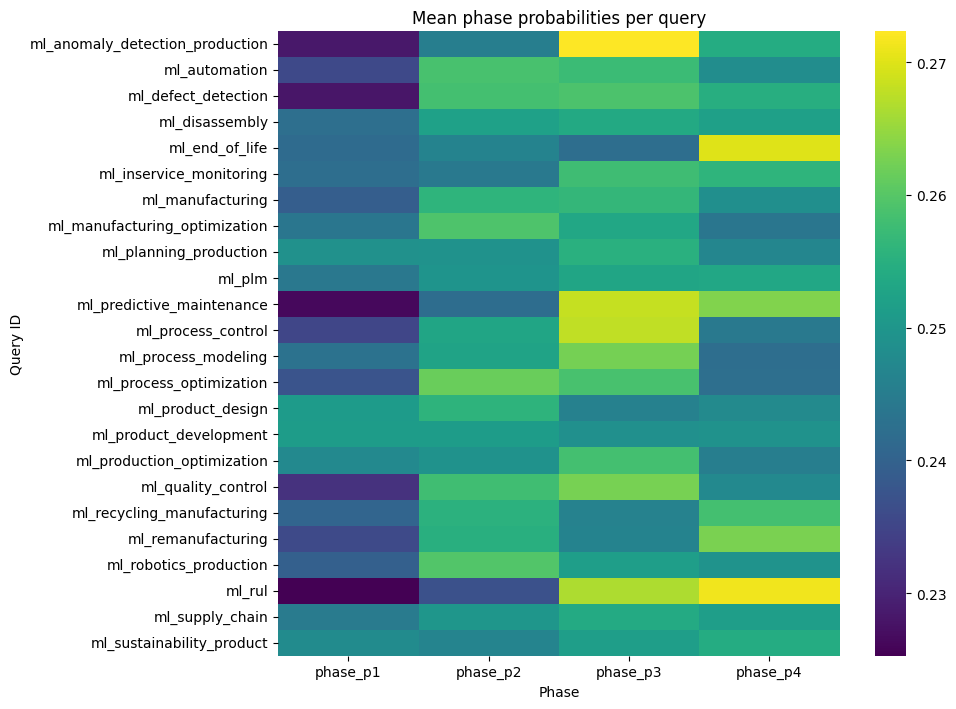

In [20]:
# Plot heatmap of mean phase probabilities per query_id

import seaborn as sns  # if you are OK adding seaborn

plt.figure(figsize=(10, len(query_phase_means) * 0.3))
sns.heatmap(
    query_phase_means[phase_prob_cols],
    annot=False,
    cmap="viridis",
    cbar=True
)
plt.xlabel("Phase")
plt.ylabel("Query ID")
plt.title("Mean phase probabilities per query")
plt.tight_layout()
plt.show()


In [21]:
# Show the most confident abstracts for each phase (primary_phase)
cols_show = [
    "query_id", "doi", "primary_phase", "phase_max_prob", "phase_margin",
    "title", "clean_abs"
]

for p in [1, 2, 3, 4]:
    print(f"\nMost confident Phase {p} abstracts\n")
    
    df_phase = df[df["primary_phase"] == p]
    top_conf = df_phase.sort_values("phase_max_prob", ascending=False).head(5)
    
    display(top_conf[cols_show])



Most confident Phase 1 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
45999,ml_production_optimization,10.1007/s11625-017-0521-6,1,0.287704,0.046677,Assessment of mitigation strategies as tools f...,Although the world understands the possible th...
18664,ml_manufacturing,10.1002/smr.2247,1,0.284508,0.040305,A proposed framework for improved software req...,Software requirement engineering (SRE) is the ...
37221,ml_product_design,10.1145/3640429.3640437,1,0.284409,0.030001,Design Thinking Using Qualitative Data Analysi...,Design Thinking is a human-centered approach t...
38248,ml_product_development,10.1016/j.dss.2025.114504,1,0.281278,0.035778,An exploration and exploitation of value cocre...,V.Idea screening in collaborative crowdsourcin...
39070,ml_product_development,10.1016/j.jbusres.2014.02.015,1,0.280978,0.024044,Consideration-set heuristics,Consumers often choose products by first formi...



Most confident Phase 2 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
8025,ml_manufacturing,10.1007/978-3-031-78747-8,2,0.297410,0.057167,CAD-based Programming for Design and Manufactu...,This book offers a thorough examination of CAD...
48589,ml_robotics_production,10.1007/978-3-030-62746-1_54,2,0.295679,0.045740,Research and Development of Simulation System ...,With the increasing demand for automation of p...
27104,ml_planning_production,10.1109/AI4I49448.2020.00015,2,0.293903,0.048682,Towards a user-centered development process of...,"The paradigm shift in manufacturing, the trans..."
18840,ml_manufacturing,10.1016/j.addma.2019.101003,2,0.293718,0.047741,Building free-form thin shell parts using supp...,V.Conventional material extrusion additive man...
48087,ml_robotics_production,10.54808/ICSIT2025.01.9,2,0.292472,0.036108,Technology Enhanced Teaching for an Industry 4...,All Rights Reserved.The mission of engineering...



Most confident Phase 3 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
18806,ml_manufacturing,10.1109/TII.2019.2940099,3,0.316873,0.074587,Performance Supervised Fault Detection Schemes...,This article addresses performance supervised ...
34552,ml_process_control,10.1080/00207543.2020.1812750,3,0.313953,0.069077,Nonparametric monitoring of multivariate data ...,Process monitoring of multivariate quality att...
33545,ml_process_control,10.1002/qre.3356,3,0.311460,0.061475,A new multivariate extended homogeneously weig...,Statistical process monitoring (SPM) provides ...
35192,ml_process_control,10.1016/j.procir.2015.12.054,3,0.311106,0.073528,Design Performance Analysis of a Self-Organizi...,"In industrial applications, the continuously g..."
34276,ml_process_control,10.1080/00401706.2021.1929493,3,0.310487,0.069121,Transparent Sequential Learning for Statistica...,Machine learning methods have been widely used...



Most confident Phase 4 abstracts



,query_id,doi,primary_phase,phase_max_prob,phase_margin,title,clean_abs
47896,ml_remanufacturing,10.1016/j.wasman.2014.11.024,4,0.300221,0.065357,An investigation of used electronics return fl...,Consumers often have a tendency to store their...
14453,ml_manufacturing,10.1007/978-981-19-6383-4_30,4,0.298301,0.053952,Experimental Analysis on Aging Evaluation of T...,Transformer aging is the most significant feat...
49089,ml_rul,10.1109/TIM.2025.3562242,4,0.296931,0.045549,A Global Adversarial and Local Contrastive Tra...,The transfer learning method can effectively m...
51870,ml_sustainability_product,10.1109/ICASI60819.2024.10547722,4,0.296125,0.050849,Remaining Value Estimation of Smartphones Appl...,The composition of increasing attention to sus...
48903,ml_rul,10.1002/9781119933175.ch5,4,0.295845,0.035482,Unveiling the future: Residual life prediction...,All rights reserved.This book chapter delves i...
